In [19]:
import pandas as pd
from pathlib import Path
import numpy as np
import os

def load_circuit_data(circuitnr, path: str):
    """
    Load the csv data (propagation, sensitively & pd) from the circuit directorys (and resamples PD to 60min)
    :param circuitnr: List of circuits to load
    :param path: Data directory path
    :return dataframe with added column(s)
    """
    circ_dir = Path(path) / str(circuitnr)
    
    df1 = pd.read_csv(circ_dir / 'Propagation.csv', sep=';', parse_dates=['Date/time (UTC)'])
    df1 = df1.rename(columns={"Propagation time (ns)": "Propagation time (ns) " + str(circuitnr)})

    df2 = pd.read_csv(circ_dir / 'Sensitivity.csv', sep=';', parse_dates=['Date/time (UTC)'])
    df2 = df2.rename(columns={"PD Detection Sensitivity (pC)": "PD Detection Sensitivity (pC) " + str(circuitnr)})

    df3 = pd.read_csv(circ_dir / 'PD.csv', sep=';', parse_dates=['Date/time (UTC)'])
    df3 = df3.drop("Location in meters (m)", axis=1)
    df3 = df3.rename(columns={"Charge (picocoulomb)": "Total charge (pC) " + str(circuitnr)})
    df3_res = df3.resample('60min', on='Date/time (UTC)').sum()

    df = pd.merge(df1, df2, on="Date/time (UTC)", how='left')
    df = pd.merge(df, df3_res, on="Date/time (UTC)", how='left')
    return df


def load_wop_data(circuitnr, path: str, resample=False):
    """
    Load the csv data (power, current & voltage) from WOP datadump and resample to 60min
    :param path: Data directory path
    :param resample: resample data to 60min if true
    :return dataframe with added column(s)
    """
    circ_dir = Path(path) / str(circuitnr)
    power_df = pd.read_csv(circ_dir / 'Power.csv', sep=';', parse_dates={'Date/time (UTC)': [' Datum', 'Tijd']},
                           date_parser=(lambda x: pd.to_datetime(x, format="%Y/%m/%d %H:%M")), decimal=',')

    power_df.drop(power_df.columns[power_df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
    if resample:
        power_df = power_df.resample('60min', on='Date/time (UTC)').mean()
    return power_df

def load_combined_data(circuitnr, path: str):
    wop_data = load_wop_data(circuitnr, path, True)
    circuit_data = load_circuit_data(circuitnr, path).resample('60min', on='Date/time (UTC)').mean()
    return pd.merge(wop_data, circuit_data, on="Date/time (UTC)", how='left')

In [38]:
df1 = load_circuit_data(3249,r'C:\Users\Davy Westra\Documents\GitHub\modellenpracticum2022-speed-of-heat\data')
print(df1)

          Date/time (UTC)  Propagation time (ns) 3249  \
0     2018-10-18 13:00:00                11553.701923   
1     2018-10-18 14:00:00                11557.158333   
2     2018-10-18 15:00:00                11561.658333   
3     2018-10-18 16:00:00                11566.900000   
4     2018-10-18 17:00:00                11574.450000   
5     2018-10-18 18:00:00                11575.791667   
6     2018-10-18 19:00:00                11569.950000   
7     2018-10-18 20:00:00                11564.133333   
8     2018-10-18 21:00:00                11557.300000   
9     2018-10-18 22:00:00                11550.108333   
10    2018-10-18 23:00:00                11545.416667   
11    2018-10-19 00:00:00                11544.346154   
12    2018-10-19 01:00:00                11540.864583   
13    2018-10-19 02:00:00                11539.989796   
14    2018-10-19 03:00:00                11538.480392   
15    2018-10-19 04:00:00                11539.019608   
16    2018-10-19 05:00:00      

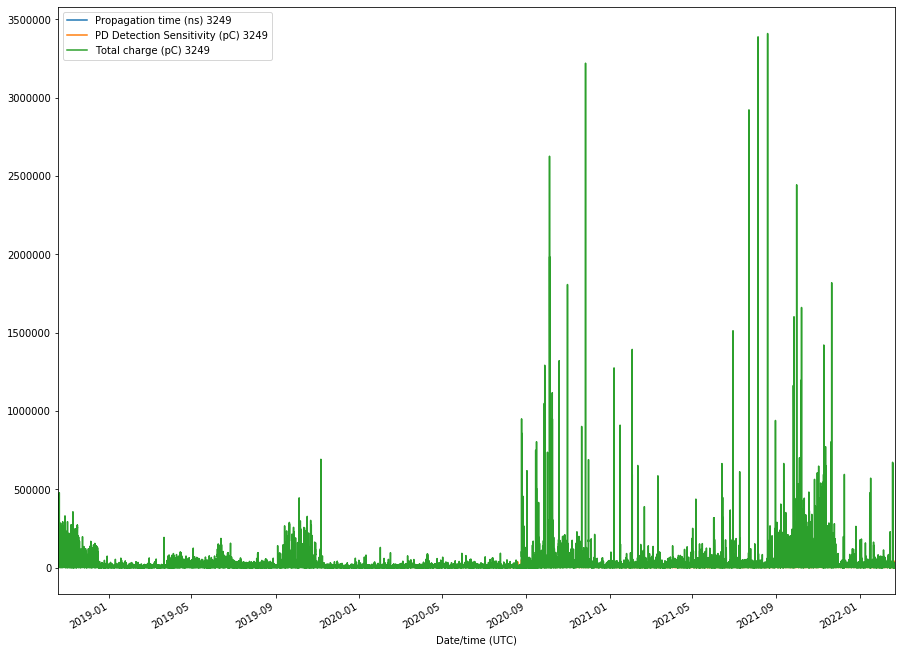

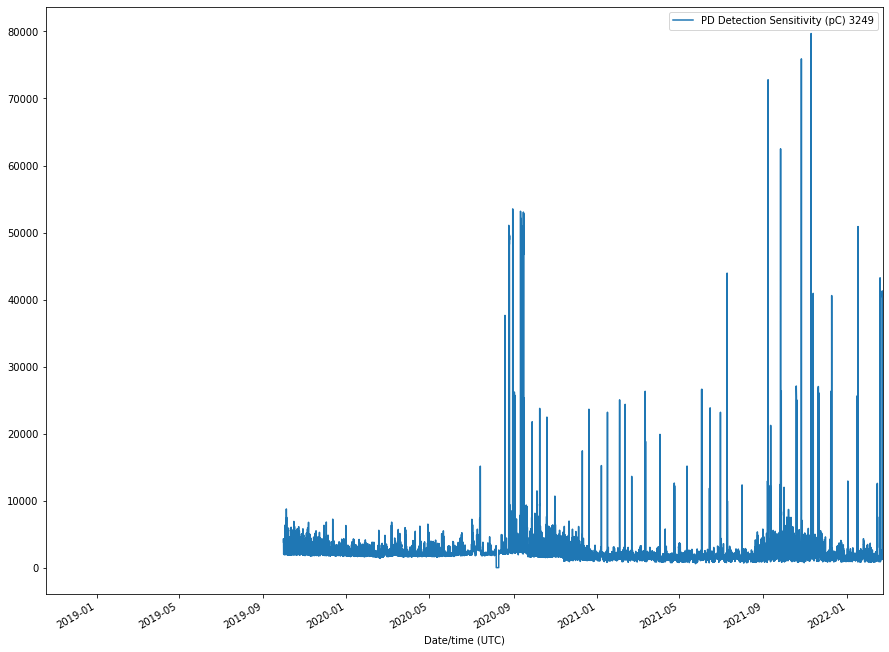

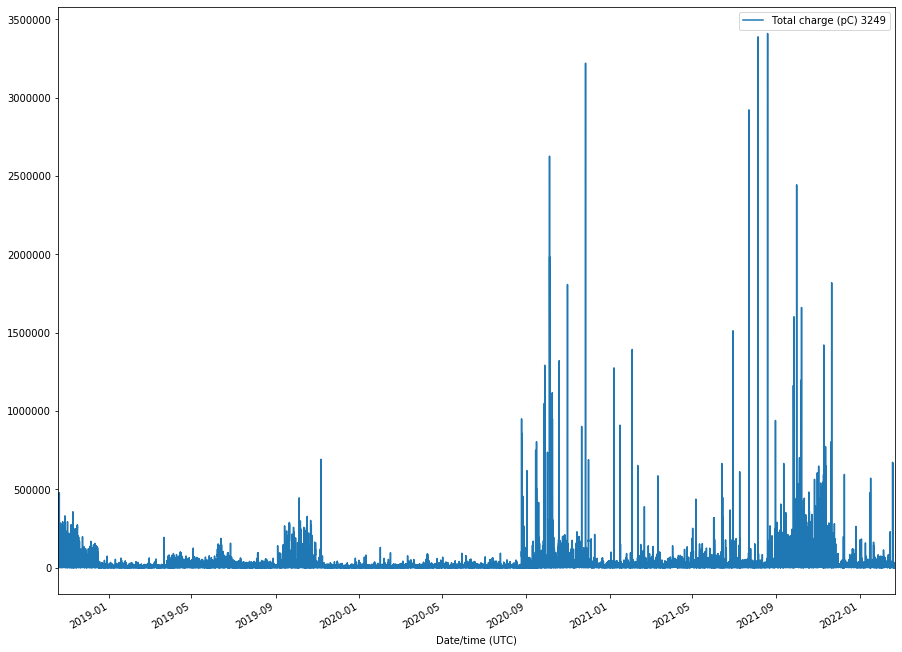

In [40]:
df1.plot(x = 'Date/time (UTC)',figsize = (15,12))
df1.plot(x = 'Date/time (UTC)',y = 'PD Detection Sensitivity (pC) 3249',figsize = (15,12))
df1.plot(x = 'Date/time (UTC)',y = 'Total charge (pC) 3249',figsize = (15,12))